<a href="https://colab.research.google.com/github/gnitnaw/LDL/blob/main/tf_framework/c17e2_multi_modal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example demonstrates how to train a classifier, using two input modalities. We use the MNIST dataset but in addition to the image modality, we also create a textual modality. More context for this code example can be found in the section "Programming Example: Classification with multimodal input data" in Chapter 17 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).

We start with initialization code and loading and standardizing the MNIST dataset in the code snippet below.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text \
    import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence \
    import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import logging
tf.get_logger().setLevel(logging.ERROR)

EPOCHS = 20
MAX_WORDS = 8
EMBEDDING_WIDTH = 4

# Load training and test datasets.
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images,
                               test_labels) = mnist.load_data()

# Standardize the data.
mean = np.mean(train_images)
stddev = np.std(train_images)
train_images = (train_images - mean) / stddev
test_images = (test_images - mean) / stddev


11490434/11490434 [==============================] - 0s 0us/step


The code snippet below creates the second input modality, which is a textual representation of each input example. To not make it too easy for the network, this textual view of the data is not complete but gives only partial information about the digit. For each training and test example, we alternate between specifying that the digit is odd or even and specifying that it is a high or low number. The textual modality created in this code snippet does not fully define what digit it is but can be helpful when an image is ambiguous.


In [3]:
# Function to create second modality.
def create_text(tokenizer, labels):
    text = []
    for i, label in enumerate(labels):
        if i % 2 == 0:
            if label < 5:
                text.append('lower half')
            else:
                text.append('upper half')
        else:
            if label % 2 == 0:
                text.append('even number')
            else:
                text.append('odd number')
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text)
    return text

# Create second modality for training and test set.
vocabulary = ['lower', 'upper', 'half', 'even', 'odd', 'number']
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(vocabulary)
train_text = create_text(tokenizer, train_labels)
test_text = create_text(tokenizer, test_labels)


The image classification network is similar to the example c5e1_mnist_learning but with an additional subnetwork that processes the textual input. This subnetwork consists of an Embedding layer and an LSTM layer. The output of the LSTM layer is concatenated with the image input and fed to a fully connected layer. This layer is followed by the final fully connected softmax layer that produces the classification. The implementation is shown below.

In [4]:
# Create model with functional API.
image_input = Input(shape=(28, 28))
text_input = Input(shape=(2, ))

# Declare layers.
embedding_layer = Embedding(output_dim=EMBEDDING_WIDTH,
                            input_dim = MAX_WORDS)
lstm_layer = LSTM(8)
flatten_layer = Flatten()
concat_layer = Concatenate()
dense_layer = Dense(25,activation='relu')
output_layer = Dense(10, activation='softmax')

# Connect layers.
embedding_output = embedding_layer(text_input)
lstm_output = lstm_layer(embedding_output)
flatten_output = flatten_layer(image_input)
concat_output = concat_layer([lstm_output, flatten_output])
dense_output = dense_layer(concat_output)
outputs = output_layer(dense_output)

# Build and train model.
model = Model([image_input, text_input], outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics =['accuracy'])
model.summary()
history = model.fit([train_images, train_text], train_labels,
                    validation_data=([test_images, test_text],
                                     test_labels), epochs=EPOCHS,
                    batch_size=64, verbose=2, shuffle=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2, 4)         32          ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 8)            416         ['embedding[0][0]']              
                                                                                              

To illustrate the effect of using the two input modalities, we do an experiment in the code snippet below. We first show all the information about a given test example. It turns out to be the digit 7, and the textual description was 'upper half'. We then use the network to make a prediction, given this image and textual description as input. We print out digits and predicted probabilities, sorted on the basis of the probabilities. The expected result is that the network correctly predicts the digit as a 7.

As a next step, we do another prediction, but this time we change the textual input to indicate 'lower half'. Looking at the probabilities, the probabilities for the high digits should now have decreased. The exact result varies, but in many cases, the probabilities changes enough so the prediction from the network changes from a 7 to a 3. This illustrates that the network has learned to take both the image and the textual description into account.


7
['upper half']


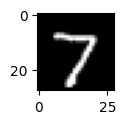

1/1 [==============================] - 1s 510ms/step
Predictions with correct input:
Digit: 7, probability: 1.00e+00
Digit: 5, probability: 1.13e-07
Digit: 9, probability: 1.06e-07
Digit: 8, probability: 1.79e-08
Digit: 3, probability: 7.67e-11
Digit: 1, probability: 7.49e-16
Digit: 2, probability: 1.22e-17
Digit: 6, probability: 1.54e-19
Digit: 4, probability: 1.01e-19
Digit: 0, probability: 3.08e-20

Predictions with incorrect input:
1/1 [==============================] - 0s 24ms/step
Digit: 7, probability: 5.68e-01
Digit: 3, probability: 4.32e-01
Digit: 2, probability: 5.81e-05
Digit: 1, probability: 8.65e-06
Digit: 9, probability: 9.06e-07
Digit: 8, probability: 3.84e-07
Digit: 0, probability: 2.42e-07
Digit: 4, probability: 2.41e-07
Digit: 5, probability: 1.12e-08
Digit: 6, probability: 9.09e-19


In [5]:
# Print input modalities and output for one test example.
print(test_labels[0])
print(tokenizer.sequences_to_texts([test_text[0]]))
plt.figure(figsize=(1, 1))
plt.imshow(test_images[0], cmap=plt.get_cmap('gray'))
plt.show()

# Predict test example.
y = model.predict([test_images[0:1], np.array(
    tokenizer.texts_to_sequences(['upper half']))])[0] #7
print('Predictions with correct input:')
for i in range(len(y)):
    index = y.argmax()
    print('Digit: %d,' %index, 'probability: %5.2e' %y[index])
    y[index] = 0

# Predict same test example but with modified textual description.
print('\nPredictions with incorrect input:')
y = model.predict([test_images[0:1], np.array(
    tokenizer.texts_to_sequences(['lower half']))])[0] #7
for i in range(len(y)):
    index = y.argmax()
    print('Digit: %d,' %index, 'probability: %5.2e' %y[index])
    y[index] = 0
